In [26]:
pip install pmdarima

In [27]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Read Data

In [28]:
df=pd.read_excel('/content/drive/MyDrive/elai/othervariety.xlsx',index_col='Price Date',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (2319, 1)


Max Price
Price Date           
2010-01-05       1601
2010-01-06       1755
2010-01-07       1741
2010-01-11       1501
2010-01-12       1454

In [50]:
ts_data = df[['Max Price']].copy()
ts_data = ts_data.asfreq('D')  # Set the frequency to daily
# Fill missing values using linear interpolation
ts_data = ts_data.interpolate(method='linear')
# Optionally, you can also perform backfill (use the next available value)
# for any remaining missing values at the beginning of the time series
ts_data = ts_data.bfill()
if ts_data.isnull().values.any():
  ts_data = ts_data.fillna(method='ffill') 

#Plot Your Data

<Axes: xlabel='Price Date'>

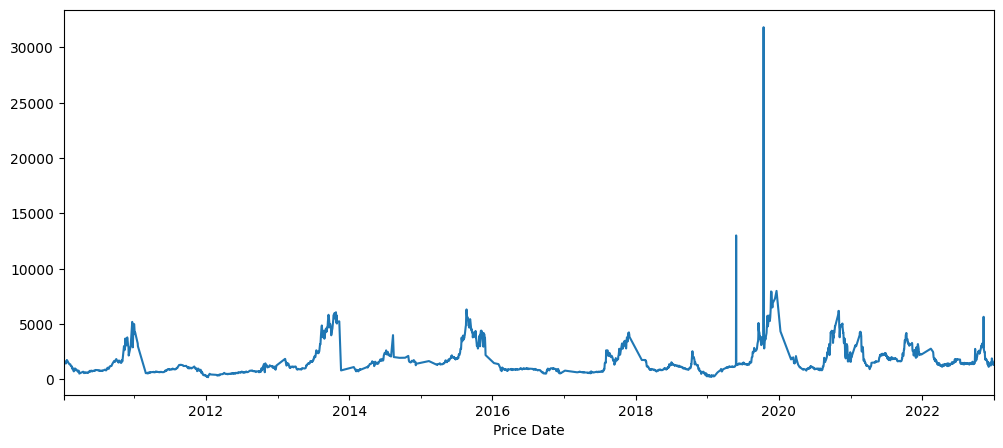

In [51]:
ts_data['Max Price'].plot(figsize=(12,5))

#Check For Stationarity

In [52]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [53]:
adf_test(ts_data['Max Price'])

1. ADF :  -4.3780982129394515
2. P-Value :  0.0003244754328155476
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 4736
5. Critical Values :
	 1% :  -3.4317315134887325
	 5% :  -2.862150472083723
	 10% :  -2.56709495631684


#Figure Out Order for ARIMA Model

In [32]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [54]:
stepwise_fit = auto_arima(ts_data['Max Price'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4744
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -36426.453
Date:                Thu, 18 May 2023   AIC                          72856.906
Time:                        08:17:53   BIC                          72869.835
Sample:                    01-05-2010   HQIC                         72861.450
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7254      0.001   -637.408      0.000      -0.728      -0.723
sigma2      2.743e+05    184.912   1483.352      0.000    2.74e+05    2.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):         710186929.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              21.10   Skew:                            34.67
Prob(H) (two-sided):                  0.00   Kurtosis:                      1897.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
from statsmodels.tsa.arima.model import ARIMA

#Split Data into Training and Testing

In [56]:
print(ts_data.shape)

(4744, 1)


In [57]:
train=ts_data.iloc[:-30]
test=ts_data.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(4714, 1) (30, 1)
Max Price    1397.0
Name: 2022-12-02 00:00:00, dtype: float64 Max Price    1360.0
Name: 2022-12-31 00:00:00, dtype: float64


In [58]:
train.tail()

Max Price
Price Date           
2022-11-27    1658.25
2022-11-28    1572.50
2022-11-29    1486.75
2022-11-30    1401.00
2022-12-01    1332.00

In [62]:
test.tail()

Max Price
Price Date           
2022-12-27     1600.5
2022-12-28     1561.0
2022-12-29     1540.0
2022-12-30     1301.0
2022-12-31     1360.0

## Train the Model

In [60]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Max Price'],order=(0,1,1))
model=model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Max Price   No. Observations:                 4714
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -36209.789
Date:                Thu, 18 May 2023   AIC                          72423.577
Time:                        08:19:13   BIC                          72436.494
Sample:                    01-05-2010   HQIC                         72428.118
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7257      0.001   -633.514      0.000      -0.728      -0.723
sigma2      2.759e+05    187.082   1474.716      0.000    2.76e+05    2.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):         698170984.79
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              21.09   Skew:                            34.59
Prob(H) (two-sided):                  0.00   Kurtosis:                      1887.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Make Predictions on Test Set

<Axes: xlabel='Price Date'>

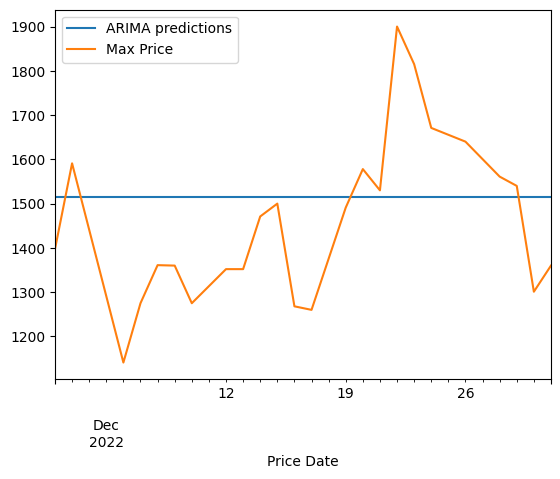

In [63]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2022-12-02',end='2022-12-31')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['Max Price'].plot(legend=True)


<Axes: xlabel='Price Date'>

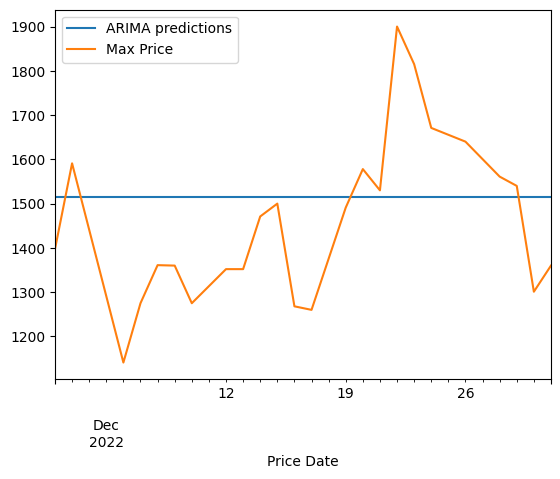

In [64]:
pred.plot(legend='ARIMA Predictions')
test['Max Price'].plot(legend=True)

In [65]:
test['Max Price'].mean()

1455.5666666666666

In [66]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Max Price']))
print(rmse)


183.11694812379827


In [68]:
model2=ARIMA(df['Max Price'],order=(0,1,1))
model2=model2.fit()
ts_data.tail()

Max Price
Price Date           
2022-12-27     1600.5
2022-12-28     1561.0
2022-12-29     1540.0
2022-12-30     1301.0
2022-12-31     1360.0

#For Future Dates

In [69]:
index_future_dates=pd.date_range(start='2022-12-31',end='2023-01-30')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2022-12-31    1464.481942
2023-01-01    1464.481942
2023-01-02    1464.481942
2023-01-03    1464.481942
2023-01-04    1464.481942
2023-01-05    1464.481942
2023-01-06    1464.481942
2023-01-07    1464.481942
2023-01-08    1464.481942
2023-01-09    1464.481942
2023-01-10    1464.481942
2023-01-11    1464.481942
2023-01-12    1464.481942
2023-01-13    1464.481942
2023-01-14    1464.481942
2023-01-15    1464.481942
2023-01-16    1464.481942
2023-01-17    1464.481942
2023-01-18    1464.481942
2023-01-19    1464.481942
2023-01-20    1464.481942
2023-01-21    1464.481942
2023-01-22    1464.481942
2023-01-23    1464.481942
2023-01-24    1464.481942
2023-01-25    1464.481942
2023-01-26    1464.481942
2023-01-27    1464.481942
2023-01-28    1464.481942
2023-01-29    1464.481942
2023-01-30    1464.481942
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

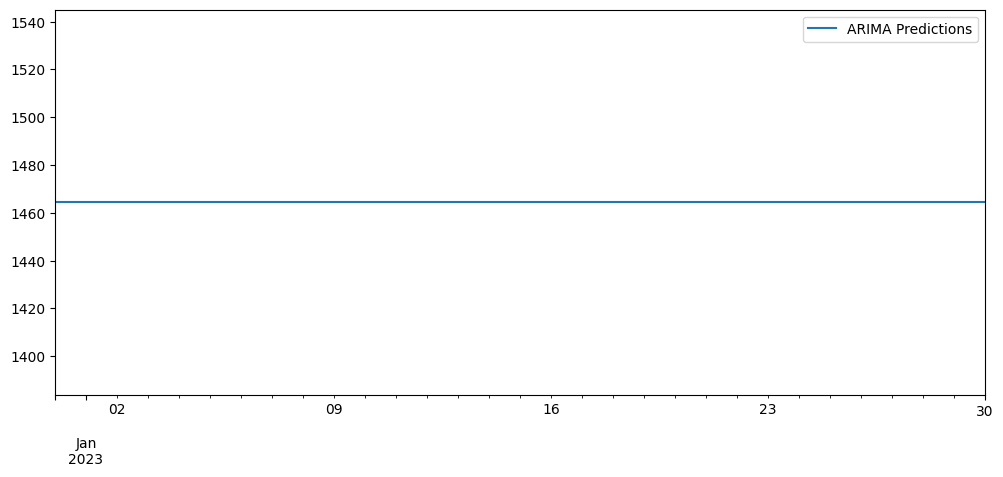

In [70]:
pred.plot(figsize=(12,5),legend=True)
